<a href="https://colab.research.google.com/github/ScienceFair2018/Adveserial-AI-FRT/blob/main/Adversarial_AI_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install facenet-pytorch

In [ ]:
import torch
from collections import OrderedDict
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import torch.nn.functional as F
from torchvision.transforms.functional import resize
from torchvision.transforms.functional import to_pil_image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


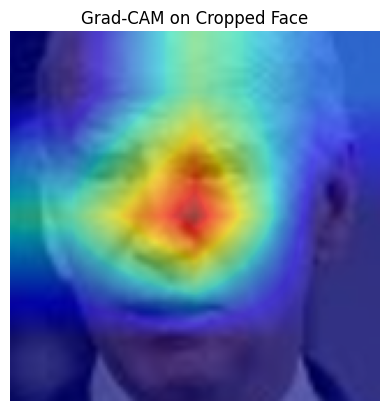

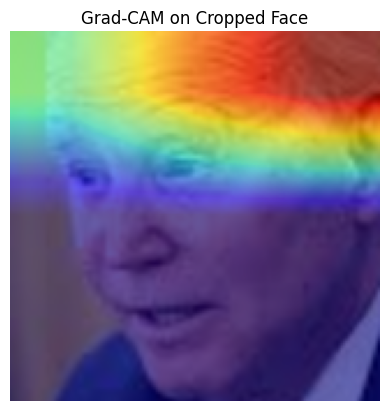

Cosine similarity between faces: 0.8254


In [ ]:

# -------------------- Grad-CAM Class -------------------- #
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()
        input_tensor = input_tensor.unsqueeze(0).requires_grad_(True)

        output = self.model(input_tensor)
        target = output.mean()
        target.backward()

        # Compute weighted sum
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = torch.relu(cam)

        # Normalize
        cam -= cam.min()
        cam /= cam.max()
        return cam


# -------------------- Utility Functions -------------------- #
def initialize_mtcnn():
    return MTCNN(image_size=160, margin=20, min_face_size=40)


def initialize_facenet(device='cpu'):
    model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
    return model


def process_image(image_path, mtcnn, device='cpu'):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((512, 512))  # prevent overload before MTCNN
    face = mtcnn(image)
    if face is None:
        raise ValueError(f"No face detected in {image_path}")
    return face.to(device), image


def embeddings(model, face_tensor):
    with torch.no_grad():
        return model(face_tensor.unsqueeze(0)).squeeze().cpu().numpy()


def compare_images(embedding1, embedding2):
    return 1 - cosine(embedding1, embedding2)


def plot_gradcam_on_image(face_np, gradcam):
    """
    Overlays Grad-CAM on a cropped face image.
    face_np: numpy array of shape [H, W, C] with values in [-1, 1] or [0, 1]
    gradcam: 2D torch.Tensor heatmap
    """
    # Clamp or normalize input to [0, 1] if needed
    if face_np.min() < 0:
        face_np = (face_np + 1) / 2  # convert [-1, 1] → [0, 1]
    face_np = np.clip(face_np, 0, 1)

    gradcam_np = gradcam.cpu().numpy()
    heatmap = np.array(
        Image.fromarray(gradcam_np).resize((face_np.shape[1], face_np.shape[0]), resample=Image.BILINEAR)
    )

    plt.imshow(face_np)
    plt.imshow(heatmap, cmap='jet', alpha=0.6)
    plt.axis('off')
    plt.title("Grad-CAM on Cropped Face")
    plt.show()


# -------------------- Main Logic -------------------- #
if __name__ == "__main__":
    image1_path = "/content/drive/MyDrive/Thesis/Adversarial-AI-FRT/biden1.jpg"
    image2_path = "/content/drive/MyDrive/Thesis/Adversarial-AI-FRT/biden2.jpg"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    mtcnn = initialize_mtcnn()
    model = initialize_facenet(device)
    target_layer = model.block8  # or block8 for deeper features

    try:
        # Load and process both faces
        face1, orig1 = process_image(image1_path, mtcnn, device)
        face2, orig2 = process_image(image2_path, mtcnn, device)

        # Generate Grad-CAM heatmaps
        cam_generator = GradCAM(model, target_layer)
        gradcam1 = cam_generator.generate(face1)
        gradcam2 = cam_generator.generate(face2)

        # Plot Grad-CAM overlays
        plot_gradcam_on_image(face1.permute(1, 2, 0).cpu().numpy(), gradcam1)
        plot_gradcam_on_image(face2.permute(1, 2, 0).cpu().numpy(), gradcam2)


        # Compare embeddings
        embedding1 = embeddings(model, face1)
        embedding2 = embeddings(model, face2)
        similarity = compare_images(embedding1, embedding2)
        print(f"Cosine similarity between faces: {similarity:.4f}")

    except Exception as e:
        print("Error:", e)


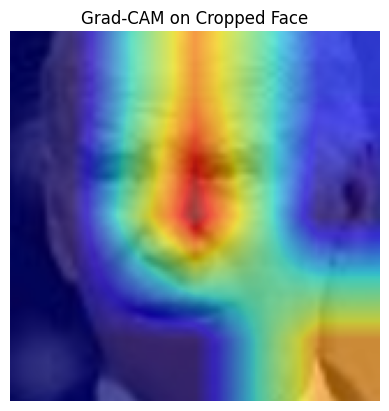

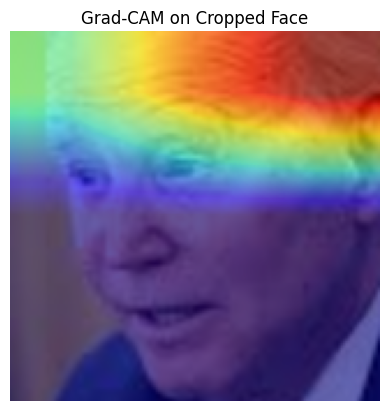

Cosine similarity between faces: 0.8121


In [ ]:
#EDITED BIDEN COMPARISON

# -------------------- Main Logic -------------------- #
if __name__ == "__main__":
    image1_path = "/content/drive/MyDrive/Thesis/Adversarial-AI-FRT/biden edited.jpg"
    image2_path = "/content/drive/MyDrive/Thesis/Adversarial-AI-FRT/biden2.jpg"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    mtcnn = initialize_mtcnn()
    model = initialize_facenet(device)
    target_layer = model.block8  # or block8 for deeper features

    try:
        # Load and process both faces
        face1, orig1 = process_image(image1_path, mtcnn, device)
        face2, orig2 = process_image(image2_path, mtcnn, device)

        # Generate Grad-CAM heatmaps
        cam_generator = GradCAM(model, target_layer)
        gradcam1 = cam_generator.generate(face1)
        gradcam2 = cam_generator.generate(face2)

        # Plot Grad-CAM overlays
        plot_gradcam_on_image(face1.permute(1, 2, 0).cpu().numpy(), gradcam1)
        plot_gradcam_on_image(face2.permute(1, 2, 0).cpu().numpy(), gradcam2)


        # Compare embeddings
        embedding1 = embeddings(model, face1)
        embedding2 = embeddings(model, face2)
        similarity = compare_images(embedding1, embedding2)
        print(f"Cosine similarity between faces: {similarity:.4f}")

    except Exception as e:
        print("Error:", e)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


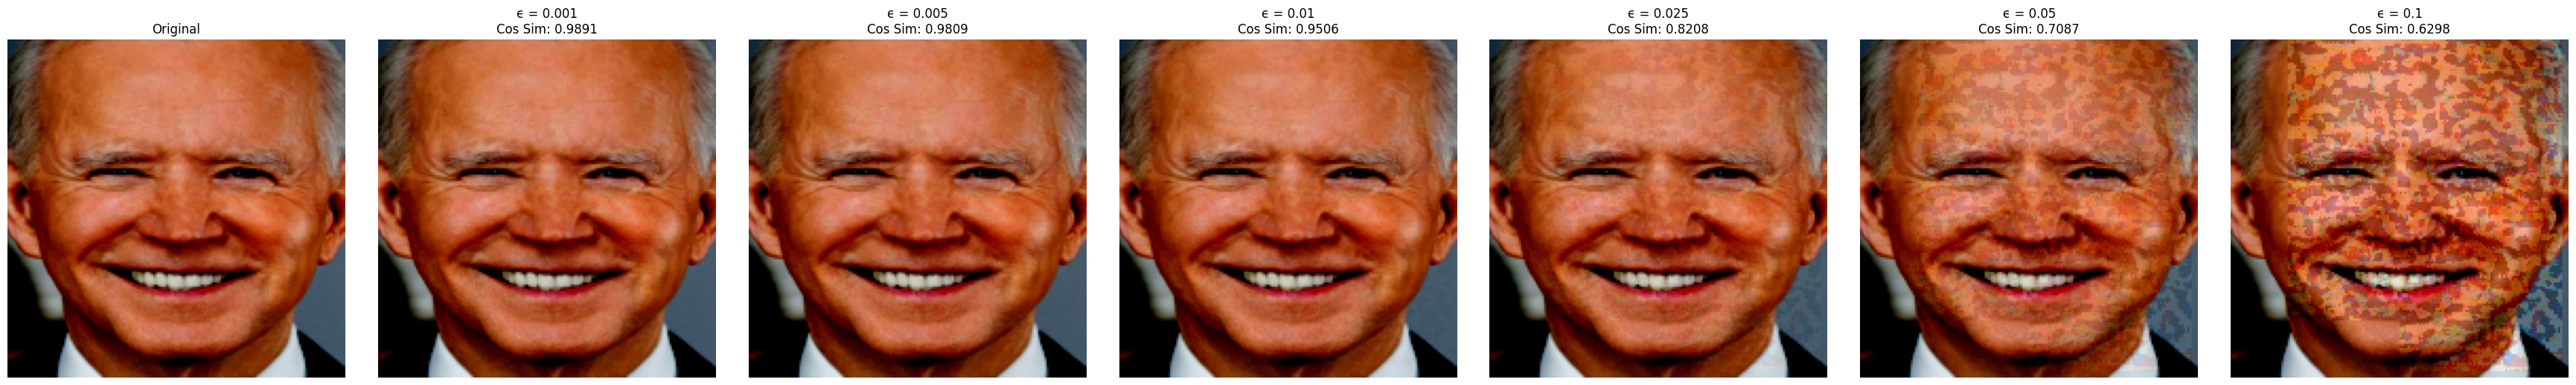

In [ ]:
############ FGSM ########################
epsilon = 0.1

def initialize_mtcnn():
    mtcnn = MTCNN(image_size=160, margin=20, min_face_size =40)
    return mtcnn

def initialize_facenet():
    model = InceptionResnetV1(pretrained='vggface2').eval()
    return model

def process_image(image_path, mtcnn):
    image = Image.open(image_path)
    face = mtcnn(image)
    if face is None:
        raise ValueError("No face detected! Try again!")
    return face

def embeddings(model, face_tensor):
    face_tensor = face_tensor.unsqueeze(0)
    with torch.no_grad():
        embedding = model(face_tensor)
    return embedding.squeeze().numpy()

def compare_images(embedding1, embedding2):
    similarity = 1 - cosine(embedding1, embedding2)
    return similarity

def gradcam(model, face_tensor, target_layer):
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    hook_backward = target_layer.register_backward_hook(backward_hook)
    hook_forward = target_layer.register_forward_hook(forward_hook)

    face_tensor = face_tensor.unsqueeze(0)
    face_tensor.requires_grad = True
    output = model(face_tensor)

    target_neuron = output.mean()
    target_neuron.backward()

    activations = activations[0].detach()
    gradients = gradients[0].detach()

    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
    gradcam = torch.sum(weights * activations, dim=1).squeeze()
    gradcam = torch.relu(gradcam)

    gradcam = gradcam - gradcam.min()
    gradcam = gradcam / gradcam.max()

    hook_backward.remove()
    hook_forward.remove()

    return gradcam

def plot_gradcam(image_path, gradcam, face_tensor):
    gradcam_np = gradcam.numpy()

    # Resize the Grad-CAM to match the original image dimensions
    original_image = Image.open(image_path)
    gradcam_resized = np.array(Image.fromarray(gradcam_np).resize(original_image.size, resample=Image.BILINEAR))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(8, 8))
    plt.imshow(original_image)
    plt.imshow(gradcam_resized, cmap='jet', alpha=0.6)  # Adjust alpha for better focus
    plt.axis('off')
    plt.title("Grad-Cam Visualization")
    plt.show()

def fgsm_attack_with_gradcam(model, image, epsilon, gradcam_map):
    image = image.clone().detach().requires_grad_(True)

    # Forward + backward
    output = model(image.unsqueeze(0))
    loss = output.mean()
    model.zero_grad()
    loss.backward()

    grad = image.grad.data

    # Resize Grad-CAM (assumes normalized already)
    cam = gradcam_map.clone().detach().unsqueeze(0).unsqueeze(0)
    cam_resized = F.interpolate(cam, size=image.shape[1:], mode='bilinear', align_corners=False).squeeze(0)

    focused_grad = grad * cam_resized
    perturbed = image + epsilon * focused_grad.sign()

    # Clamp to valid pixel range
    perturbed = torch.clamp(perturbed, 0, 1)

    return perturbed

def generate_targeted_adversarial_image(model, face_tensor, gradcam, epsilon):
    face_tensor.requires_grad = True

    # Forward pass
    output = model(face_tensor.unsqueeze(0))
    target_neuron = output.mean()  # Use mean as a proxy target (e.g., similarity score)

    # Backward pass
    model.zero_grad()
    target_neuron.backward()

    # Get gradients of the input image
    data_grad = face_tensor.grad.data

    # Generate adversarial image with focused perturbations
    perturbed_image = fgsm_attack_with_gradcam(face_tensor, epsilon, data_grad, gradcam)
    return perturbed_image

def show_original_and_adversarial(original, adversarial):
    """
    Display the original and adversarial face tensors side by side.
    """
    original_np = original.detach().cpu().permute(1, 2, 0).numpy()
    adversarial_np = adversarial.detach().cpu().permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_np)
    axes[0].set_title("Original Face")
    axes[0].axis('off')

    axes[1].imshow(adversarial_np)
    axes[1].set_title("FGSM Adversarial Face")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    image2 = "/content/drive/MyDrive/Thesis/Adversarial-AI-FRT/joe_biden.jpeg"

    mtcnn = initialize_mtcnn()
    model = initialize_facenet()
    target_layer = model.block8

    try:
        original_image = Image.open(image2)
        face = process_image(image2, mtcnn)
        gradcam_map = gradcam(model, face, target_layer)
        embedding_orig = embeddings(model, face)

        epsilon_values = [0.001, 0.005, 0.01, 0.025, 0.05, 0.1]

        fig, axes = plt.subplots(1, len(epsilon_values) + 1, figsize=(5 * (len(epsilon_values) + 1), 5))

        # Original image
        original_np = face.detach().cpu().permute(1, 2, 0).numpy()
        axes[0].imshow(original_np)
        axes[0].set_title("Original")
        axes[0].axis('off')

        for idx, eps in enumerate(epsilon_values):
            face_clone = face.clone().detach().requires_grad_(True)
            adversarial = fgsm_attack_with_gradcam(model, face_clone, eps, gradcam_map)
            embedding_adv = embeddings(model, adversarial)
            similarity = compare_images(embedding_orig, embedding_adv)

            adv_np = adversarial.detach().cpu().permute(1, 2, 0).numpy()
            adv_np = np.clip(adv_np, 0, 1)

            axes[idx + 1].imshow(adv_np)
            axes[idx + 1].set_title(f"ϵ = {eps}\nCos Sim: {similarity:.4f}")
            axes[idx + 1].axis('off')

        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(e)


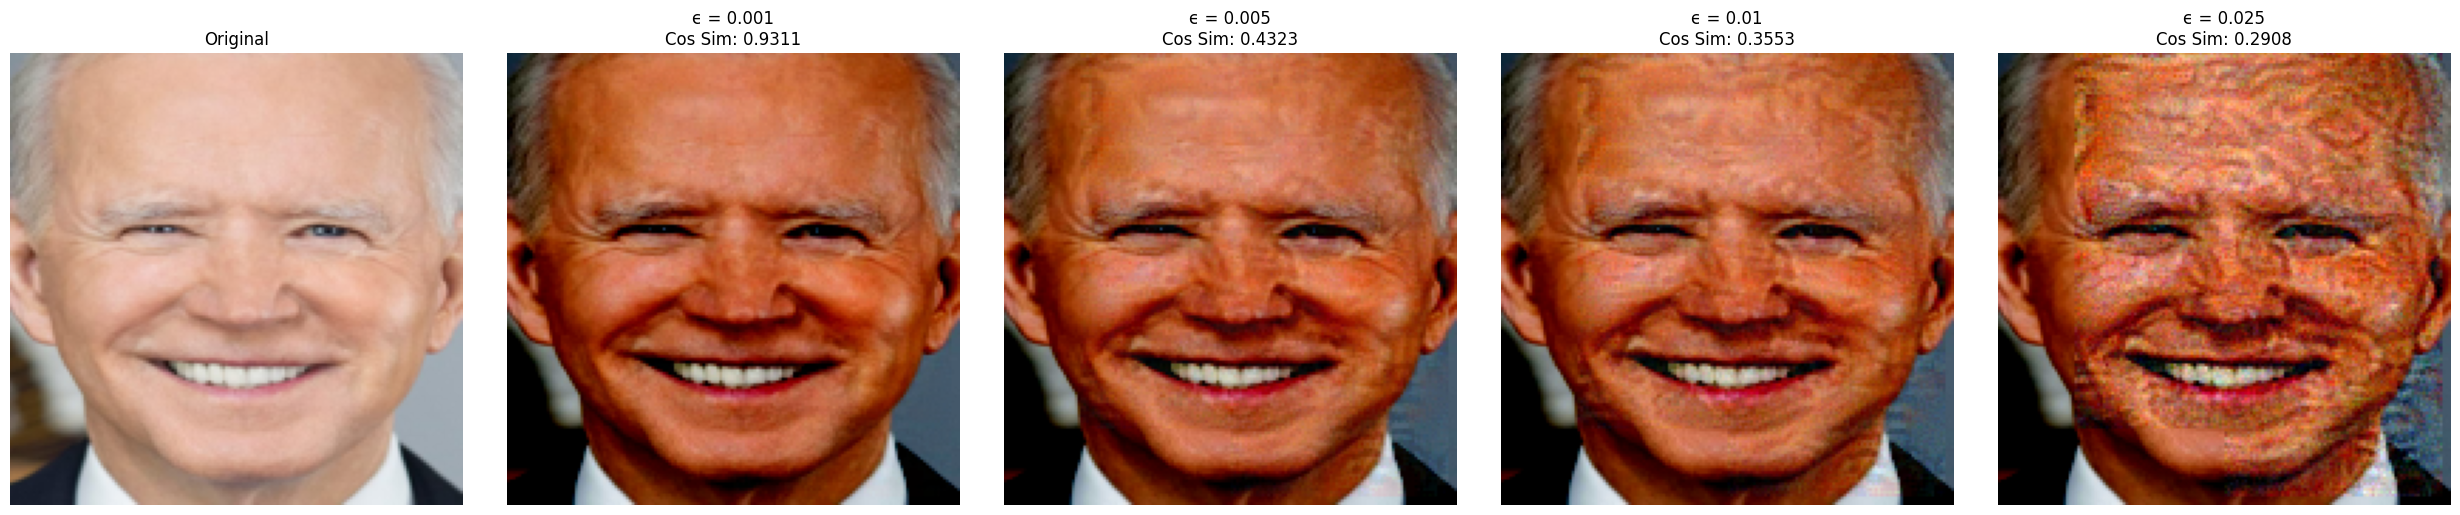

In [ ]:
######## PGD ##############
num_steps = 10  # Number of PGD steps

def pgd_attack(model, face_tensor, epsilon, num_steps, gradcam_map, alpha=None):
    if alpha is None:
        alpha = epsilon / num_steps

    # Normalize and resize Grad-CAM
    cam = gradcam_map / gradcam_map.max()
    cam = cam.clone().detach().unsqueeze(0).unsqueeze(0)
    cam_resized = F.interpolate(cam, size=face_tensor.shape[1:], mode='bilinear', align_corners=False).squeeze(0)

    # Initialize perturbed image with random noise within epsilon-ball
    original = face_tensor.clone().detach()
    perturbed = original + torch.empty_like(original).uniform_(-epsilon, epsilon)
    perturbed = torch.clamp(perturbed, 0, 1).detach().requires_grad_(True)

    for _ in range(num_steps):
        output = model(perturbed.unsqueeze(0))
        loss = output.mean()
        model.zero_grad()
        loss.backward()

        if perturbed.grad is None:
            break
        grad = perturbed.grad.data
        focused_grad = grad * cam_resized

        perturbed = perturbed + alpha * focused_grad.sign()
        perturbed = torch.max(torch.min(perturbed, original + epsilon), original - epsilon)
        perturbed = torch.clamp(perturbed, 0, 1).detach().requires_grad_(True)

    return perturbed


def generate_targeted_pgd_adversarial_image(model, face_tensor, gradcam_map, epsilon, num_steps=10):
    face_tensor = face_tensor.clone().detach().requires_grad_(True)

    output = model(face_tensor.unsqueeze(0))
    target_neuron = output.mean()

    model.zero_grad()
    target_neuron.backward()

    if face_tensor.grad is None:
        print("No gradients computed for face_tensor!")
        return None

    return pgd_attack_with_gradcam(face_tensor, epsilon, num_steps, gradcam_map, model)

def gradcam(model, face_tensor, target_layer):
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    hook_backward = target_layer.register_backward_hook(backward_hook)
    hook_forward = target_layer.register_forward_hook(forward_hook)

    face_tensor = face_tensor.unsqueeze(0)
    face_tensor.requires_grad = True
    output = model(face_tensor)

    target_neuron = output.mean()
    target_neuron.backward()

    activations = activations[0].detach()
    gradients = gradients[0].detach()

    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
    gradcam = torch.sum(weights * activations, dim=1).squeeze()
    gradcam = torch.relu(gradcam)

    gradcam = gradcam - gradcam.min()
    gradcam = gradcam / gradcam.max()

    hook_backward.remove()
    hook_forward.remove()

    return gradcam

if __name__ == "__main__":
    image2 = "/content/drive/MyDrive/Thesis/Adversarial-AI-FRT/joe_biden.jpeg"

    mtcnn = initialize_mtcnn()
    model = initialize_facenet()
    target_layer = model.block8  # Use target layer for Grad-CAM

    try:
        original_image = Image.open(image2)
        face = process_image(image2, mtcnn)
        gradcam_map = gradcam(model, face, target_layer)
        embedding1 = embeddings(model, face)

        # Define multiple epsilon values to test
        epsilon_values = [0.001, 0.005, 0.01, 0.025]

        fig, axes = plt.subplots(1, len(epsilon_values) + 1, figsize=(5 * (len(epsilon_values) + 1), 5))

        # Original image
        original_face_np = face.detach().cpu().permute(1, 2, 0).numpy()
        if original_face_np.min() < 0:
            original_face_np = (original_face_np + 1) / 2
        original_face_np = np.clip(original_face_np, 0, 1)
        axes[0].imshow(original_face_np)
        axes[0].set_title("Original")
        axes[0].axis('off')

        # Loop over epsilon values
        for idx, epsilon in enumerate(epsilon_values):
            adversarial = generate_targeted_pgd_adversarial_image(model, face, gradcam_map, epsilon, num_steps)

            if adversarial is not None:
                embedding_adv = embeddings(model, adversarial)
                similarity = compare_images(embedding1, embedding_adv)

                adv_np = adversarial.detach().cpu().permute(1, 2, 0).numpy()
                adv_np = np.clip(adv_np, 0, 1)
                axes[idx + 1].imshow(adv_np)
                axes[idx + 1].set_title(f"ϵ = {epsilon}\nCos Sim: {similarity:.4f}")
                axes[idx + 1].axis('off')
            else:
                axes[idx + 1].text(0.5, 0.5, f"Failed for ϵ={epsilon}", ha='center', va='center')
                axes[idx + 1].axis('off')

        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(e)


Random Noise (ϵ = 0.001): Cosine Similarity = 0.9875
Random Noise (ϵ = 0.005): Cosine Similarity = 0.9876
Random Noise (ϵ = 0.01): Cosine Similarity = 0.9880
Random Noise (ϵ = 0.025): Cosine Similarity = 0.9874
Random Noise (ϵ = 0.05): Cosine Similarity = 0.9868


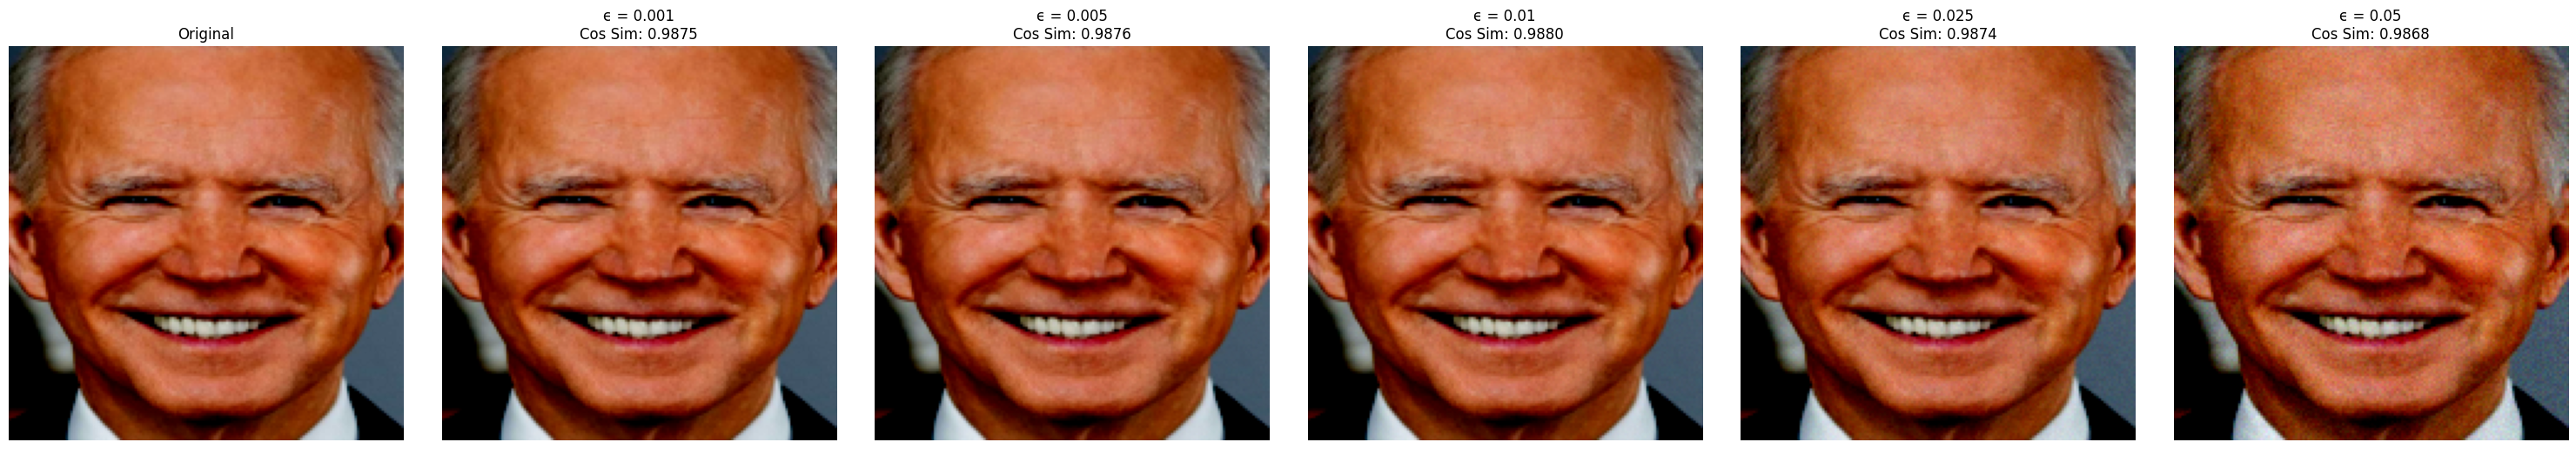

In [ ]:
def add_random_noise(image, epsilon, mode='uniform'):
    """
    Add random noise (uniform or Gaussian) to the image.
    """
    if mode == 'uniform':
        noise = torch.empty_like(image).uniform_(-epsilon, epsilon)
    elif mode == 'gaussian':
        noise = torch.empty_like(image).normal_(mean=0, std=epsilon)
    else:
        raise ValueError("Unsupported noise mode. Use 'uniform' or 'gaussian'.")

    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

# === Evaluate noise perturbations ===
epsilon_values = [0.001, 0.005, 0.01, 0.025, 0.05]
embedding_orig = embeddings(model, face)

fig, axes = plt.subplots(1, len(epsilon_values) + 1, figsize=(5 * (len(epsilon_values) + 1), 5))

# Show original image
original_np = face.detach().cpu().permute(1, 2, 0).numpy()
axes[0].imshow(original_np)
axes[0].set_title("Original")
axes[0].axis('off')

for idx, eps in enumerate(epsilon_values):
    noisy_img = add_random_noise(face, epsilon=eps, mode='uniform')
    embedding_noisy = embeddings(model, noisy_img)
    similarity = compare_images(embedding_orig, embedding_noisy)

    noisy_np = noisy_img.detach().cpu().permute(1, 2, 0).numpy()
    noisy_np = np.clip(noisy_np, 0, 1)

    axes[idx + 1].imshow(noisy_np)
    axes[idx + 1].set_title(f"ϵ = {eps}\nCos Sim: {similarity:.4f}")
    axes[idx + 1].axis('off')

    print(f"Random Noise (ϵ = {eps}): Cosine Similarity = {similarity:.4f}")

plt.tight_layout()
plt.show()

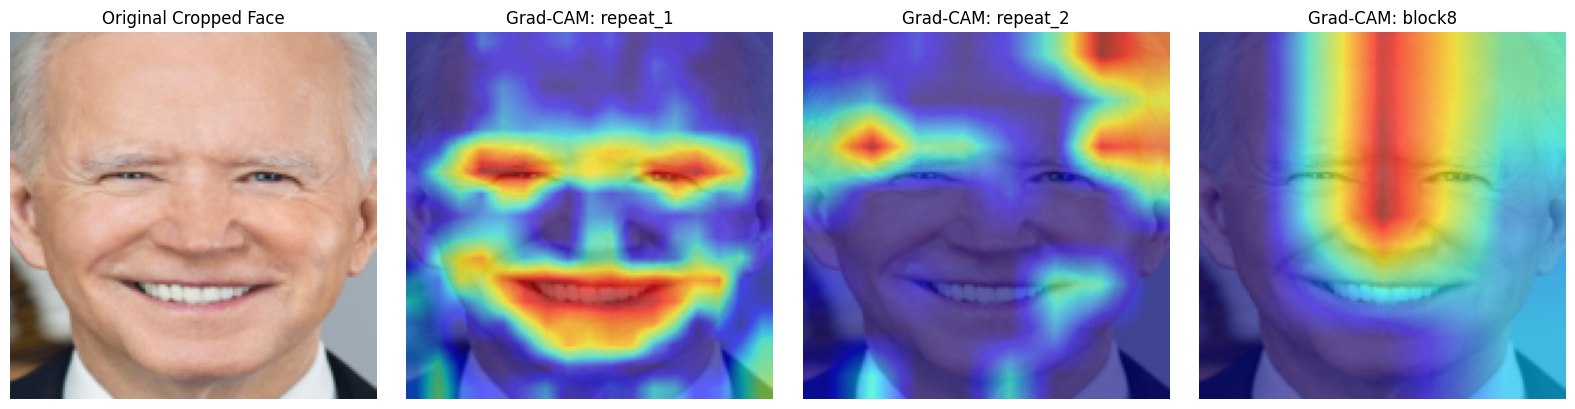

In [ ]:
# Plot multiple Grad-CAMs
def plot_gradcam_layers(face_tensor, model, layers_dict):
    face_np = face_tensor.permute(1, 2, 0).cpu().numpy()
    if face_np.min() < 0:
        face_np = (face_np + 1) / 2
    face_np = np.clip(face_np, 0, 1)

    num_layers = len(layers_dict)
    fig, axes = plt.subplots(1, num_layers + 1, figsize=(4*(num_layers + 1), 4))

    # Show original image
    axes[0].imshow(face_np)
    axes[0].set_title("Original Cropped Face")
    axes[0].axis('off')

    for i, (name, layer) in enumerate(layers_dict.items(), 1):
        cam = GradCAM(model, layer).generate(face_tensor)
        cam_np = cam.cpu().numpy()
        cam_resized = np.array(Image.fromarray(cam_np).resize((160, 160), resample=Image.BILINEAR))
        axes[i].imshow(face_np)
        axes[i].imshow(cam_resized, cmap='jet', alpha=0.6)
        axes[i].set_title(f"Grad-CAM: {name}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

model = initialize_facenet().eval()
face_tensor = process_image("/content/drive/MyDrive/Thesis/Adversarial-AI-FRT/joe_biden.jpeg", mtcnn)

# Choose multiple layers to compare
layers_to_test = {
    "repeat_1": model.repeat_1,
    "repeat_2": model.repeat_2,
    "block8": model.block8
}

plot_gradcam_layers(face_tensor, model, layers_to_test)
